# Real-ESRGAN 学习笔记
##### 张博旸 2025/4/8
Real-ESRGAN的副标题是“Training Real-World Blind Super-Resolution with Pure Synthetic Data”，它旨在ESRGAN框架的基础上，构建一个模拟真实相机/网络传播压缩等退化方式的模型，并依赖这个模型，创建一个完全合成的数据对集，以此训练一个更加拟合真实环境的超分辨率网络。

在经典的图像退化模型中，主要由以下四个部分组成：
$$
x = \mathcal{D}(y) = \left[ (y \circledast k) \downarrow_r + n \right]_{\mathrm{JPEG}}
$$
- 使用高斯模糊核k进行卷积。
- 下采样r倍。有三种下采样方式：
  - 最近邻插值：对每个像素取其最近的邻居像素值。
  - 双线性插值：对每个像素取其四个邻居像素值的加权平均。
  - 双三次插值：对每个像素取其16个邻居像素值的加权平均。
- 添加噪声n。考虑两种噪声类型：
  - 加性高斯噪声：在每个像素上添加一个高斯分布的随机数。
  - 泊松噪声：在每个像素上添加一个泊松分布的随机数。
- JPEG压缩。调用DiffJPEG库进行JPEG压缩。

可以用opencv简单实现上面的过程：

读取一张原始图像：

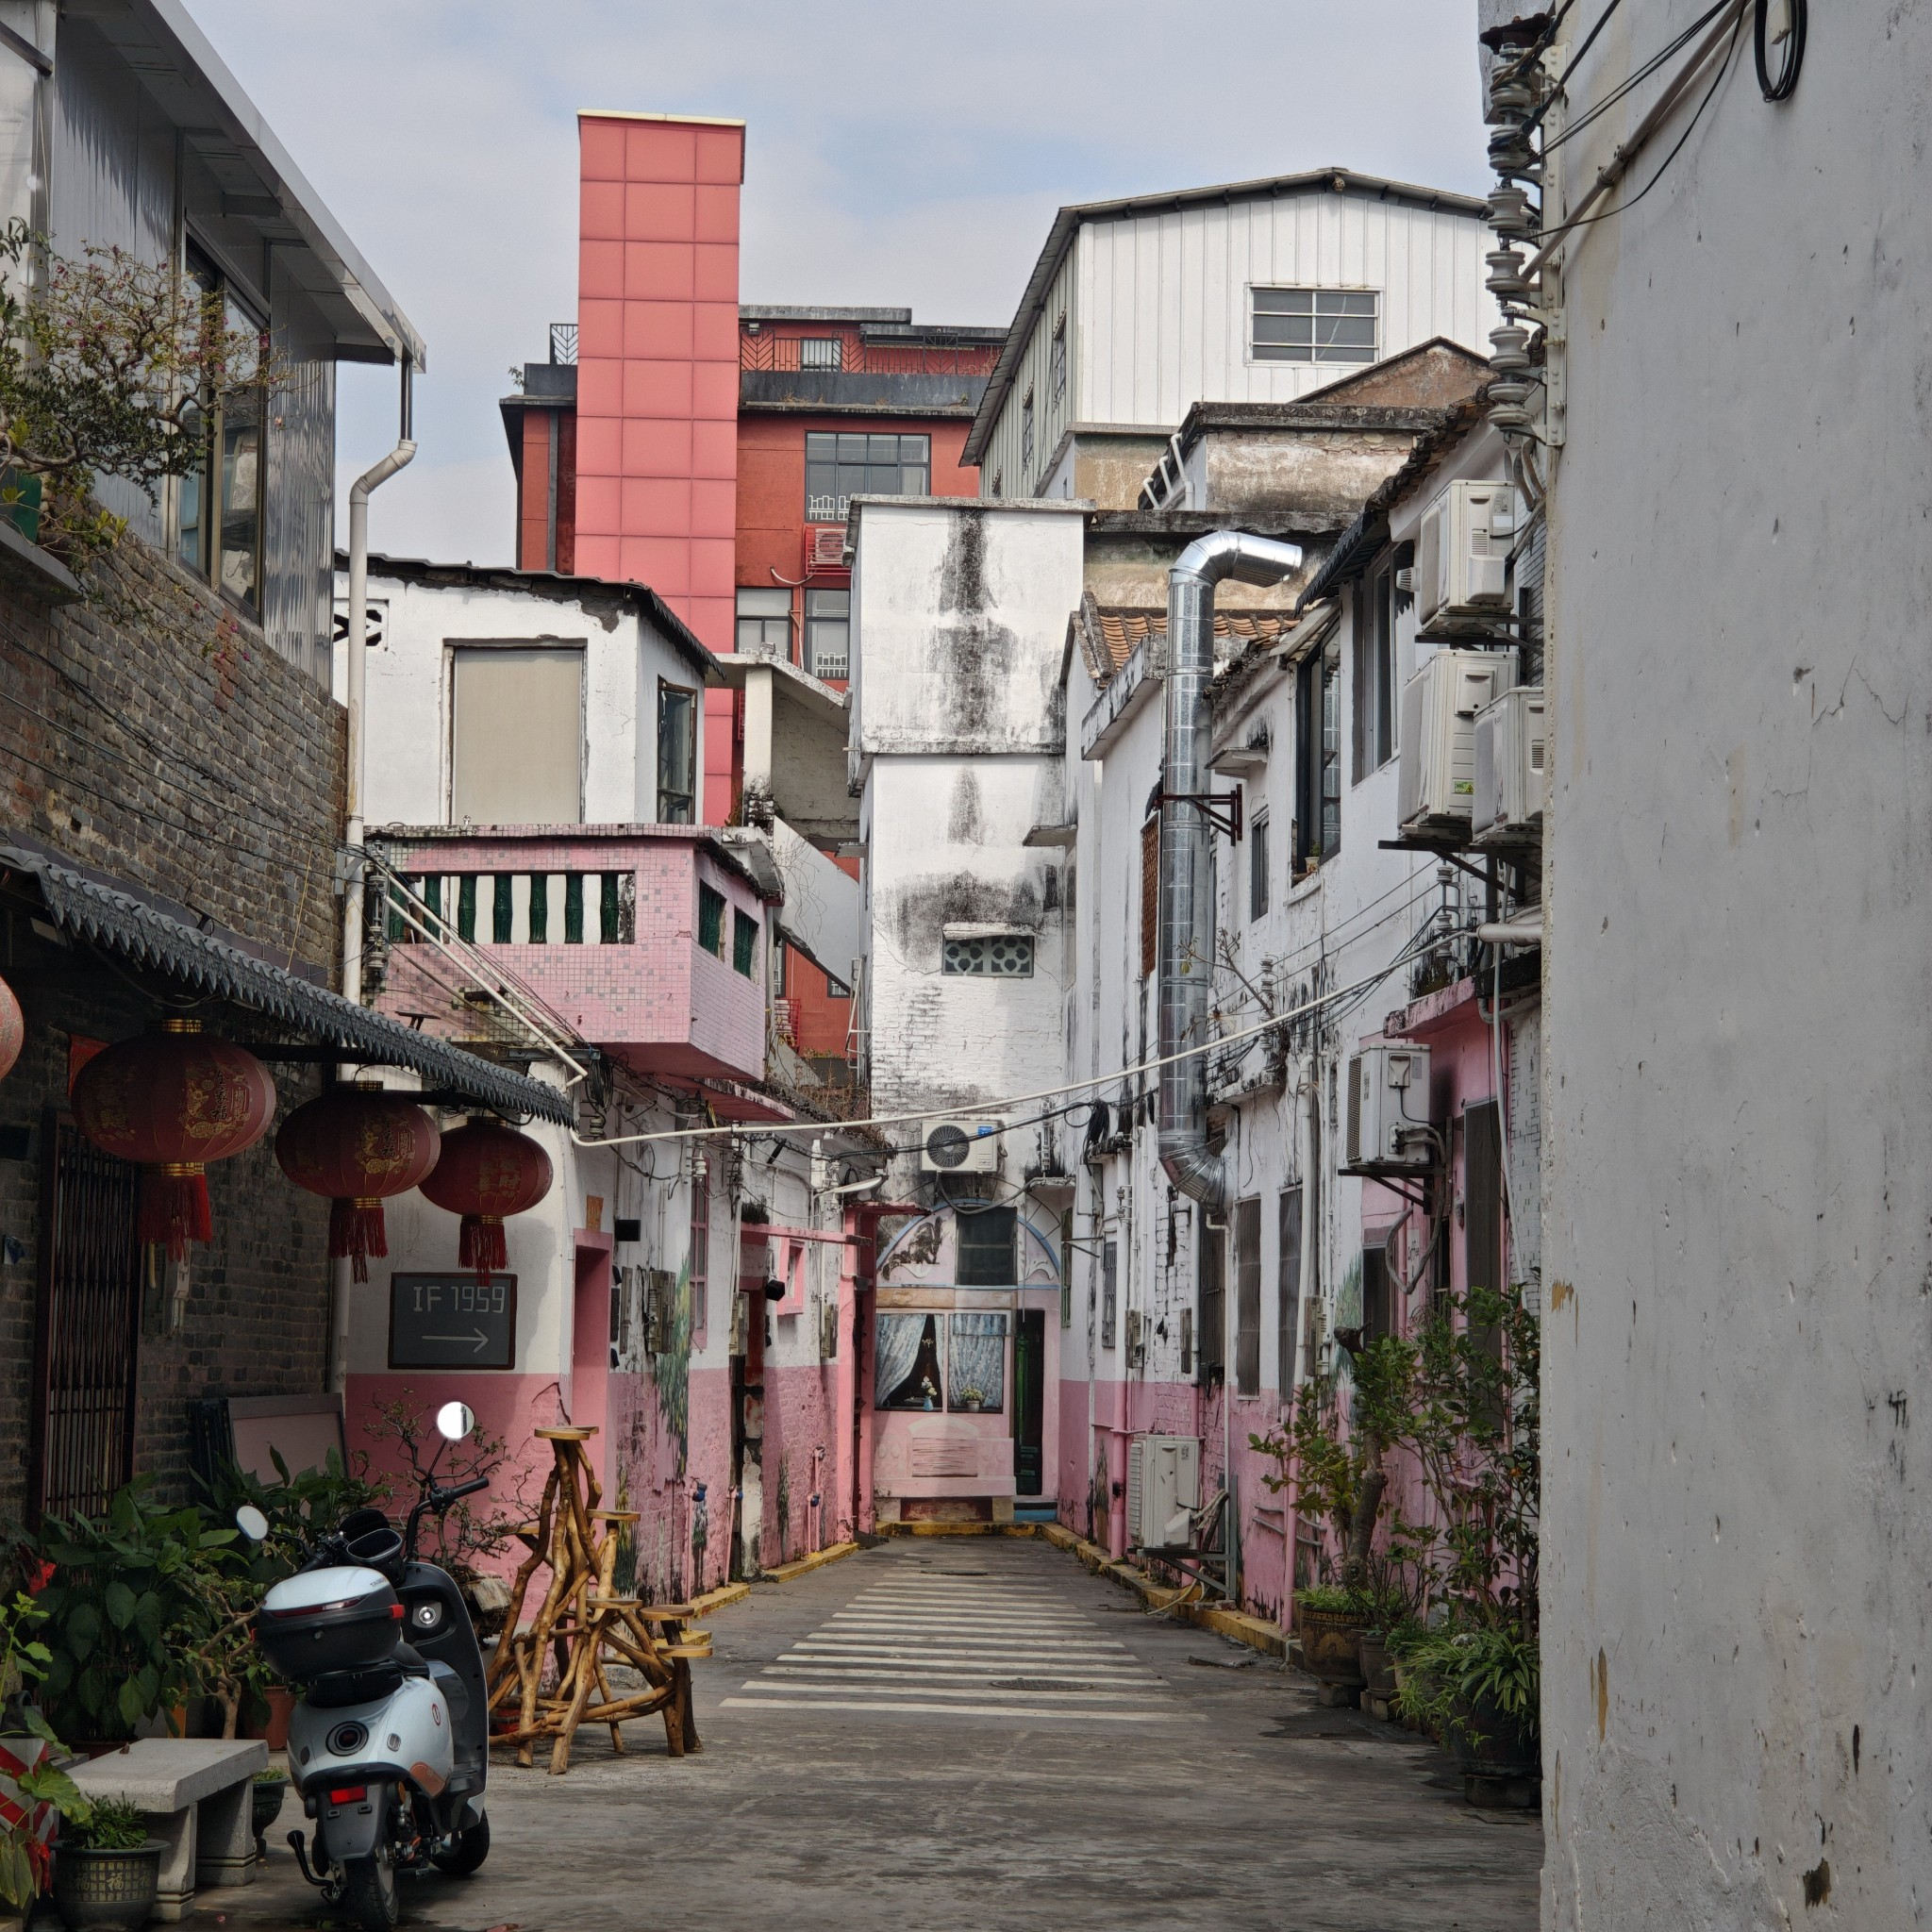

In [2]:
import cv2
import numpy as np
import random
import torch
import io
from PIL import Image
import yaml
import os
os.environ['TORCHINDUCTOR_DISABLE'] = '1'
from realesrgan.models.realesrgan_model import RealESRGANModel

from IPython.display import display, Image
demo = Image(filename='ex.png')
display(demo)

对图像进行模糊：

随机参数：kernel_size=27, sigma=3.8283189468229866


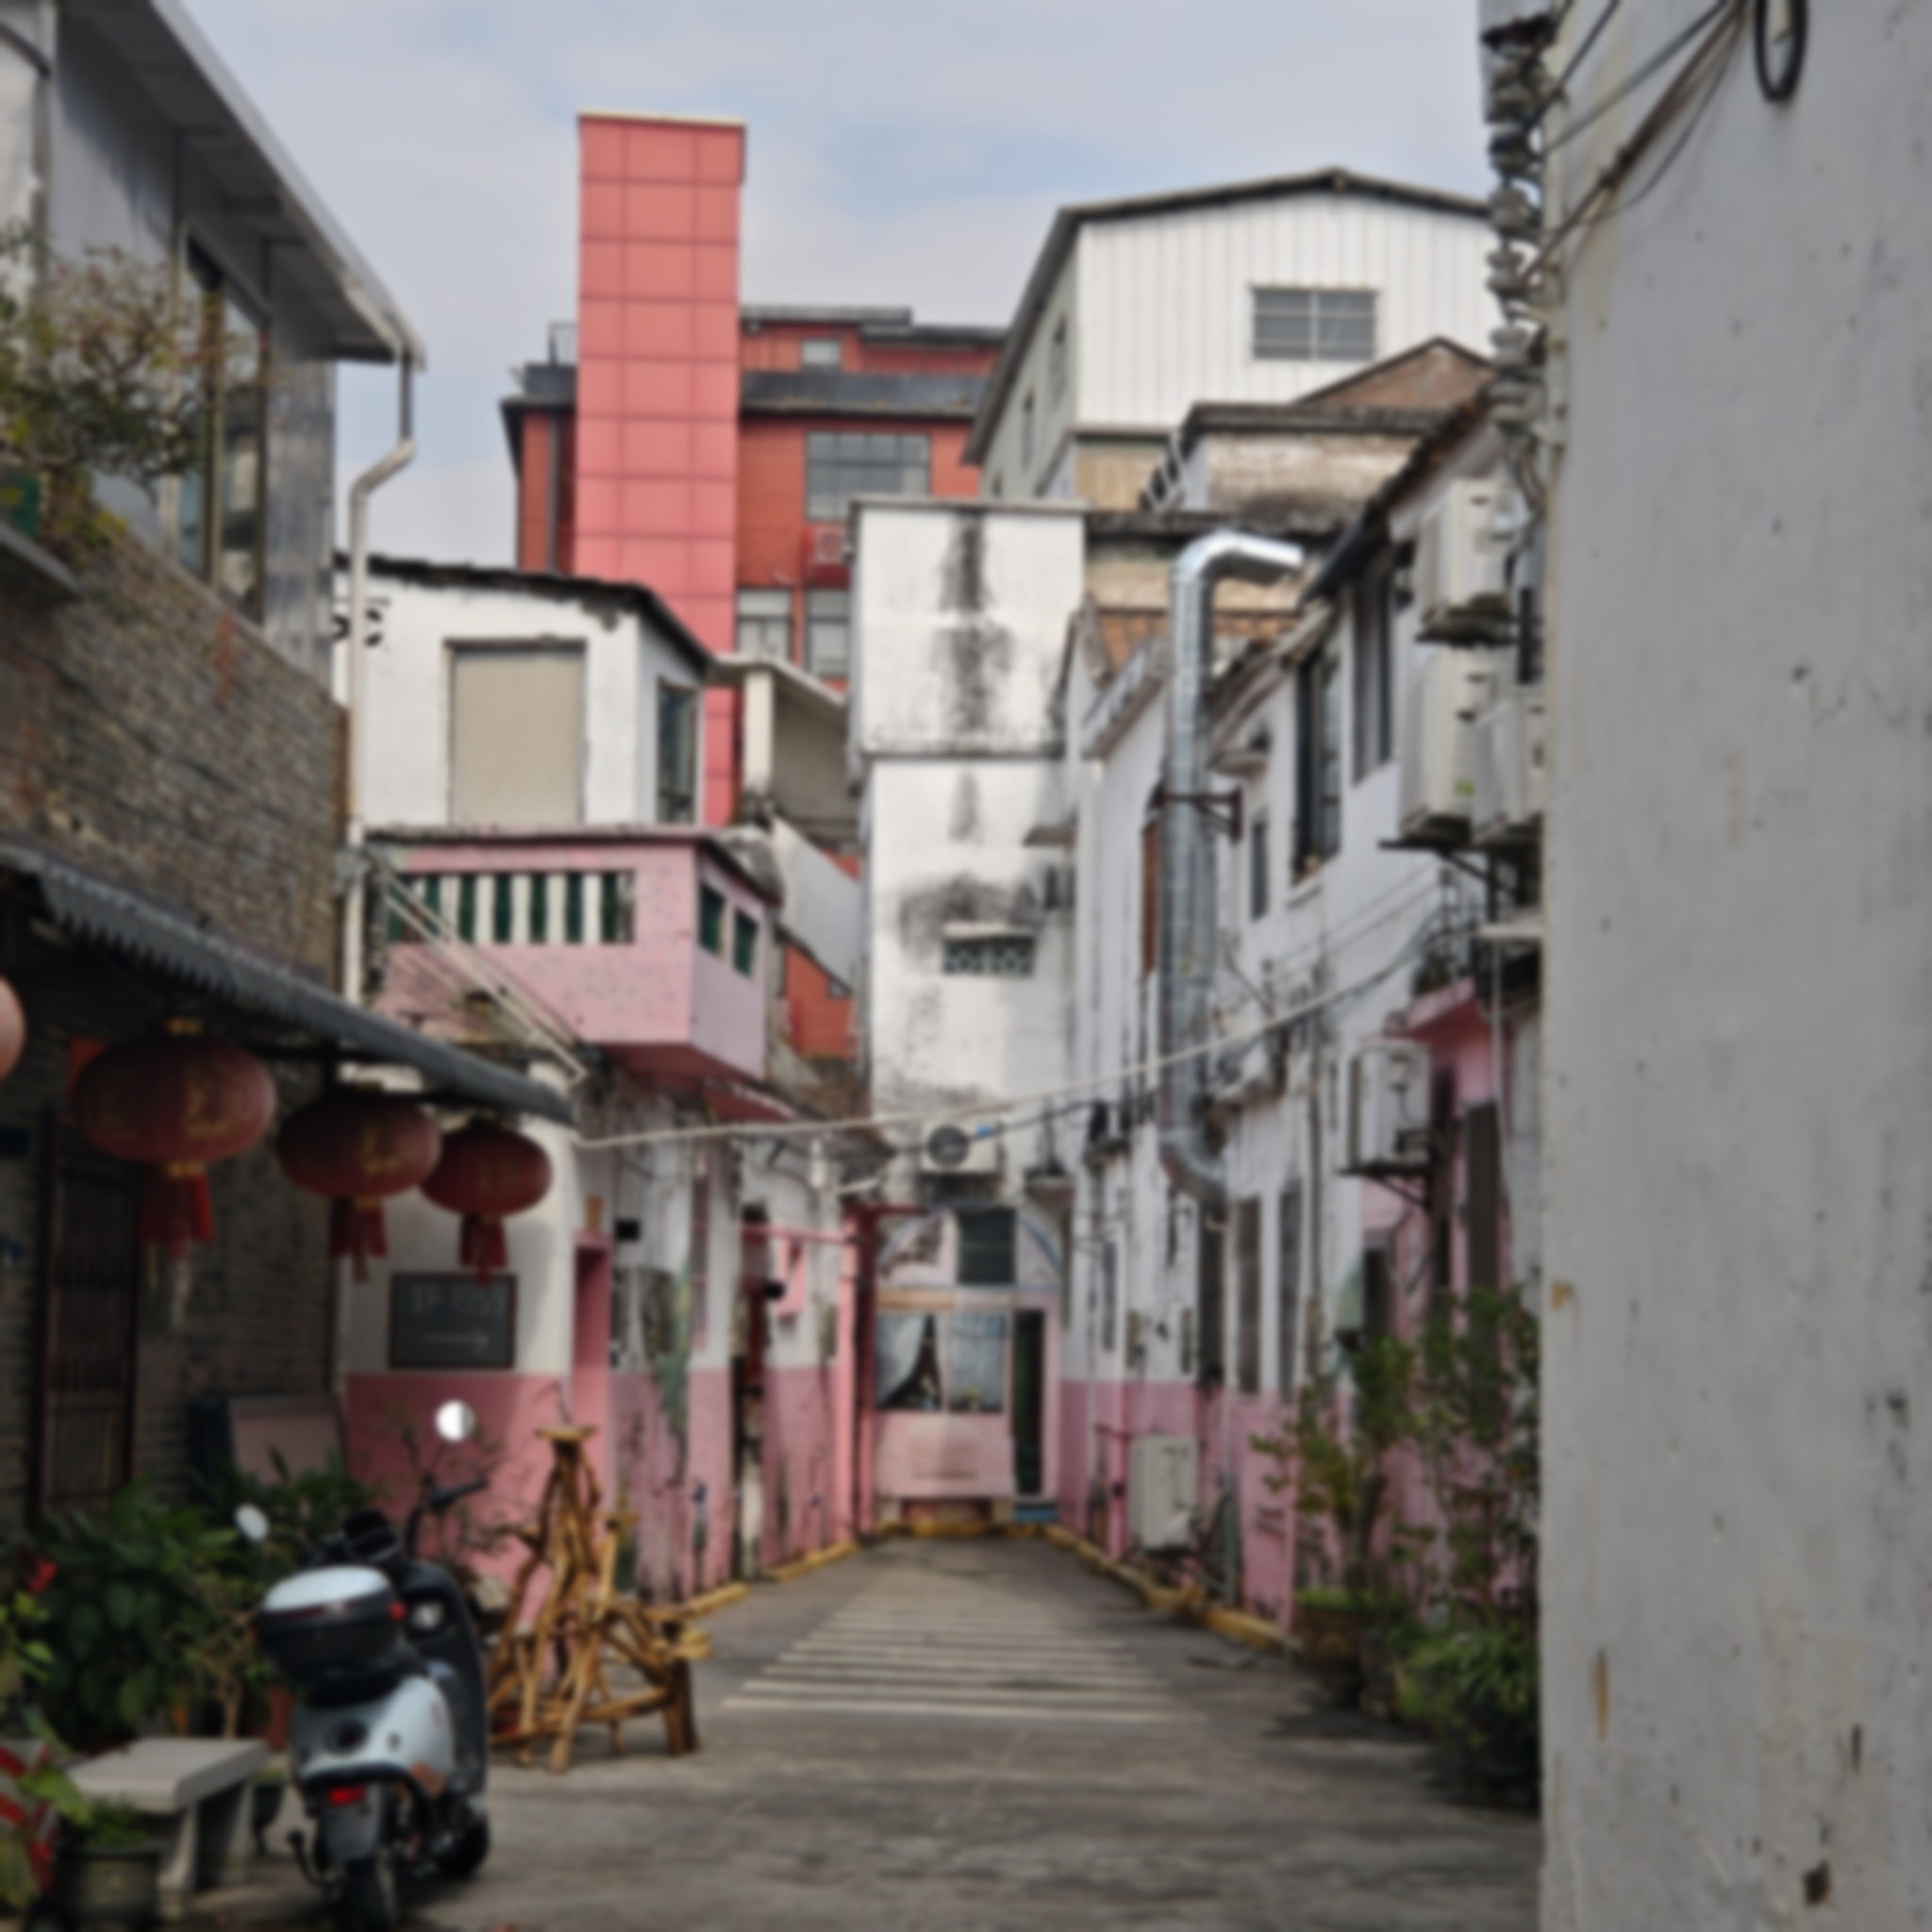

In [3]:
# 1. 高斯模糊

img = cv2.imread('ex.png')
kernel_size = random.choice([13, 27, 53, 103]) # 随机选择卷积核大小
sigma = random.uniform(0.3, 5.0) # 随机选择sigma值
# 使用cv2的高斯模糊函数进行模糊处理
blurred_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma)

# 显示模糊后的图片
cv2.imwrite('blurred_ex.jpg', blurred_img)
print(r'随机参数：kernel_size={}, sigma={}'.format(kernel_size, sigma))
display(Image(filename='blurred_ex.jpg'))

对图像进行下采样：

随机参数：scale_factor=0.10981614022225239, down_method=2


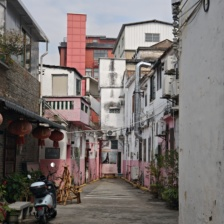

In [4]:
# 2. 下采样
scale_factor = random.uniform(0.1, 0.65)  # 随机选择缩放因子
h, w = img.shape[:2]
new_h, new_w = int(h * scale_factor), int(w * scale_factor)

# 使用cv2的resize函数进行下采样
down_method = random.choice([cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC])
downsampled = cv2.resize(blurred_img, (new_w, new_h), interpolation=down_method)

# 显示下采样后的图片
cv2.imwrite('downsampled_ex.jpg', downsampled)
print(r'随机参数：scale_factor={}, down_method={}'.format(scale_factor, down_method))
display(Image(filename='downsampled_ex.jpg'))

对图像增加噪声：

随机参数：noise_type=gaussian, var=0.030340801175853655


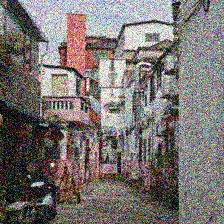

In [5]:
# 3. 增加噪声
noise_type = random.choice(['gaussian', 'poisson']) # 随机选择噪声类型
if noise_type == 'gaussian':
    # 生成高斯噪声
    mean = 0
    var = random.uniform(0.001, 0.05)
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, downsampled.shape).astype(np.float32)
    noisy = np.clip(downsampled + gauss * 255, 0, 255).astype(np.uint8)
else:
    # 生成泊松噪声
    noisy = np.random.poisson(downsampled / 255.0 * 255) / 255.0 * 255
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)

# 显示添加噪声后的图片
print(r'随机参数：noise_type={}, var={}'.format(noise_type, var))
cv2.imwrite('noisy_ex.jpg', noisy)
display(Image(filename='noisy_ex.jpg'))

对图像执行JPEG压缩：

随机参数：quality=20


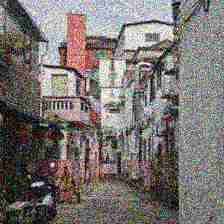

In [6]:
# 4.JPEG压缩

quality = random.randint(10, 50)  # 随机选择压缩质量

# 使用cv2的imencode函数进行JPEG压缩
encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
_, encimg = cv2.imencode('.jpg', noisy, encode_param)

# 显示JPEG压缩后的图片
jpeg_compressed = cv2.imdecode(encimg, 1)
cv2.imwrite('jpeg_compressed_ex.jpg', jpeg_compressed)
print(r'随机参数：quality={}'.format(quality))
display(Image(filename='jpeg_compressed_ex.jpg'))

对于上面经典的退化模型，可能无法生成现实中一些未知的噪声和复杂的伪影，为此作者提出了一种高阶的退化模型，这个n阶模型包含n个重复的退化步骤，每个步骤都执行一次上面的经典退化模型。过程相同，但超参数不同。
$$
\mathbf{x} = \mathcal{D}^n(\mathbf{y}) = (\mathcal{D}_n \circ \cdots \circ \mathcal{D}_2 \circ \mathcal{D}_1)(\mathbf{y}).
$$
作者在经验上最终选择了二阶退化，它在经典退化模型的基础上再执行了一次过程相同但参数不同的过程，并在退化链的最后执行了一个2D sinc 滤波器：
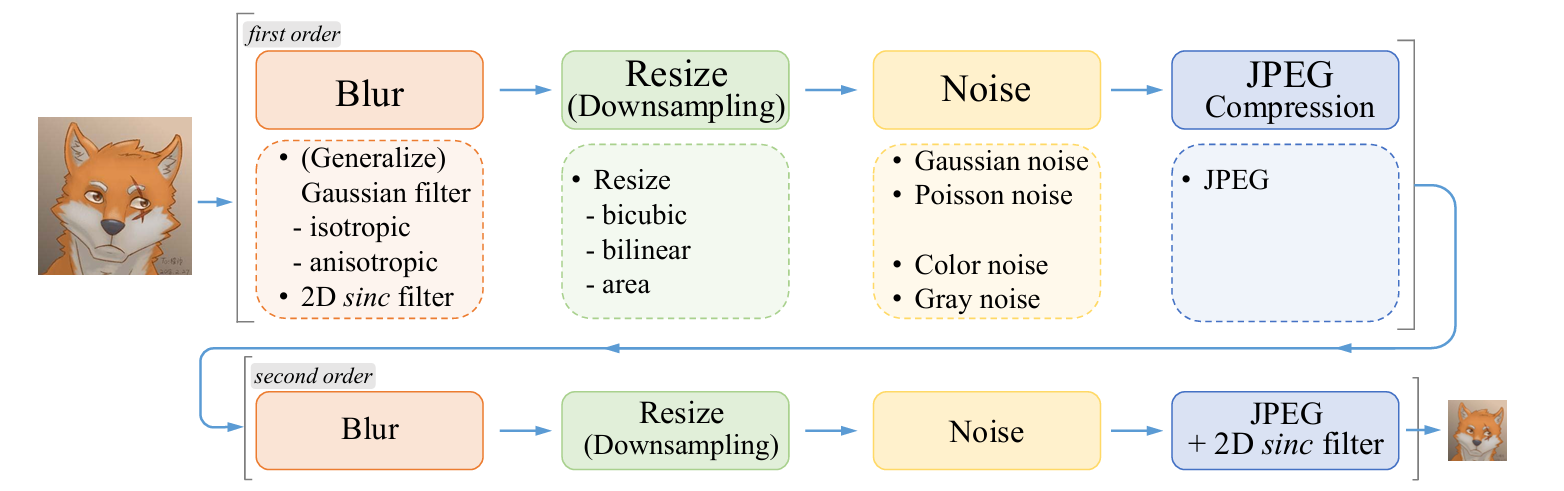

>2D sinc 滤波器在图像处理中是一种理想的低通滤波器，其在空间域中的表现与傅里叶变换中的矩形函数相对应。sinc 函数定义为 $\text{sinc}(x) = \begin{cases} \frac{\sin(\pi x)}{\pi x} & \text{if } x \neq 0 \\1 & \text{if } x = 0 \end{cases}$ 。在二维图像处理中，2D sinc 滤波器通过在两个维度上应用 sinc 函数来平滑图像，同时尽可能保留图像的高频细节。

sinc滤波器在该退化管线中起到了一个增加振铃和鬼影的作用。

下面将直接调用项目中作者的退化代码并生成一张示例图像（参数可以在get_img_test）中调整:

Used Gaussian noise
Used keep
Used Gaussian noise
Used sinc filter first
model.lq shape: torch.Size([1, 3, 512, 512])
model.lq min: 0.0
model.lq max: 1.0
degraded_img min: 0
degraded_img max: 255


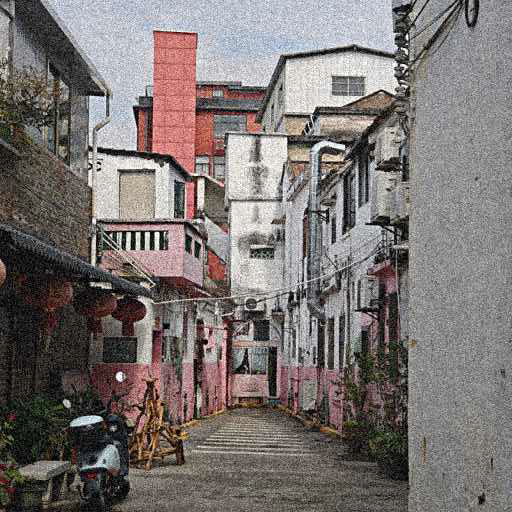

In [12]:
img = cv2.imread('ex.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_tensor = torch.from_numpy(img).float() / 255.0  # 转为 [0, 1] 范围
img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0).cuda()  # 转为 NCHW 格式

# 初始化退化模型
with open('tests/data/get_img_test.yml', mode='r') as f: # 读取配置文件
    opt = yaml.load(f, Loader=yaml.FullLoader)
model = RealESRGANModel(opt)
model.is_train = True  # 设置为训练模式

# 模拟输入数据
data = {
    'gt': img_tensor,  # 高质量图像
    'kernel1': torch.ones(1, 1).float().cuda(),  # 模拟模糊核1
    'kernel2': torch.ones(1, 1).float().cuda(),  # 模拟模糊核2
    'sinc_kernel': torch.ones(1, 1).float().cuda()  # 模拟 sinc 核
}

# 调用退化管线
model.feed_data(data)


# 获取退化后的图像
degraded_img = model.lq.squeeze(0).permute(1, 2, 0).cpu().numpy()
degraded_img = (degraded_img * 255).clip(0, 255).astype(np.uint8)

# 检查退化后的图像值范围和形状
print("model.lq shape:", model.lq.shape)
print("model.lq min:", model.lq.min().item())
print("model.lq max:", model.lq.max().item())

# 检查转换后的图像值范围
print("degraded_img min:", degraded_img.min())
print("degraded_img max:", degraded_img.max())

# 保存退化后的图像
cv2.imwrite('degraded_ex.png', cv2.cvtColor(degraded_img, cv2.COLOR_RGB2BGR))
# 显示退化后的图像
display(Image(filename='degraded_ex.png'))

在退化模型完成后，就得到了由真正图像和退化图像组成的数据对